In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from collections import defaultdict
from testsuite import TestSuite
import numpy as np
import math
import scipy.stats as stats
import util
import d4j
import os

def predict(load_func, cor_name):
    result = {
        "cls_level": [],
        "method_level": [],
        "stmt_level": [],
        "ratio": [],
        "cls_levelXratio": [],
        "method_levelXratio": [],
        "stmt_levelXratio": []
    }
    
    pvalue_insignificant = set()
    for name in d4j.NAMES:
        for bug_id in os.listdir(os.path.join(cor_name, name)):
            data = load_func(name, bug_id, "max20")
            if data is None:
                continue

            truey = data["is_bug"] == "True"
            truey = truey.astype(int)
            avg = sum(truey) / len(truey)
            if avg == 1 or avg == 0:
                continue

            def loss(y):
                return log_loss(truey, y, normalize=False)

            XX = False
            intercept_loss = loss([[1 - avg, avg]] * len(truey))
            for t in [["cls_level"], ["method_level"], ["stmt_level"], ["ratio"], ["cls_level", "ratio"], ["method_level", "ratio"], ["stmt_level", "ratio"]]:
                X = data[t]
                clf = LogisticRegression(solver='lbfgs').fit(X, truey)
                preds = clf.predict(X)
                
                params = np.append(clf.intercept_, clf.coef_)
                newX = np.append(np.ones((len(X),1)), X, axis=1)
                MSE = (sum((truey-preds)**2))/(len(newX)-len(newX[0]))
                var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
                sd_b = np.sqrt(var_b)
                ts_b = params/ sd_b

                p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]
                if any(map(lambda x: x > 0.05, p_values)):
                    result["X".join(t)].append(None)
                    print(name, bug_id, t)
                    pvalue_insignificant.add(name + str(bug_id))
                    continue

                clf_loss = loss(clf.predict_proba(X))

                rsq = 1 - clf_loss / intercept_loss
                result["X".join(t)].append(rsq)
        
    print(pvalue_insignificant)
    print(len(pvalue_insignificant))
    return result


major = predict(util.load, "cov")
pit = predict(util.load_pit, "cov_pit")

Time 15 ['stmt_level', 'ratio']
Time 12 ['method_level', 'ratio']
Closure 111 ['cls_level', 'ratio']
Closure 164 ['cls_level', 'ratio']
Closure 132 ['method_level', 'ratio']
Ignore constant value Closure 11 max20 [0.]
Closure 98 ['cls_level', 'ratio']
Closure 67 ['method_level', 'ratio']
Closure 137 ['cls_level', 'ratio']
Lang 15 ['cls_level', 'ratio']
Lang 47 ['method_level', 'ratio']
Lang 55 ['method_level', 'ratio']
Math 91 ['method_level', 'ratio']
Math 6 ['stmt_level']
Math 71 ['cls_level', 'ratio']
Ignore constant value Chart 1 max20 [0.]
{'Math71', 'Time12', 'Closure137', 'Lang47', 'Closure132', 'Math6', 'Math91', 'Closure111', 'Closure98', 'Lang55', 'Time15', 'Lang15', 'Closure67', 'Closure164'}
14
Time 14 ['cls_level', 'ratio']
Closure 99 ['method_level', 'ratio']
Closure 132 ['method_level', 'ratio']
Closure 74 ['cls_level', 'ratio']
Ignore constant value Closure 131 max20 stmt_level
Closure 76 ['cls_level', 'ratio']
Ignore constant value Closure 165 max20 method_level
Closur

In [2]:
for n in ["cls_level", "method_level", "stmt_level"]:
    comb = "{}Xratio".format(n)
    print("Major", n, stats.wilcoxon(major[n], major[comb], alternative="less"))
    print("PIT", n, stats.wilcoxon(pit[n], pit[comb], alternative="less"))

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from collections import defaultdict
from testsuite import TestSuite
import numpy as np
import math
import scipy.stats as stats
import util
import d4j
import os
import matplotlib.pyplot as plt
import pandas as pd

def corr(load_func, cor_name):
    result = defaultdict(list)
    for name in d4j.NAMES:
        for bug_id in os.listdir(os.path.join(cor_name, name)):
            data = load_func(name, bug_id, "max20")
            if data is None:
                continue
                
            for t in ["cls_level", "method_level", "stmt_level"]:
                cor, pvalue = stats.pearsonr(data[t], data["ratio"])
                result[t].append(cor)
                
    df = pd.DataFrame(result)
    df.columns = ["Class", "Method", "Statement"]
    return df


major_cor = corr(util.load, "cov")
pit_cor = corr(util.load_pit, "cov_pit")

Ignore constant value Closure 11 max20 [0.]
Ignore constant value Chart 1 max20 [0.]
Ignore constant value Closure 131 max20 stmt_level
Ignore constant value Closure 165 max20 method_level
Ignore constant value Lang 63 max20 stmt_level
Ignore constant value Lang 6 max20 stmt_level
Ignore constant value Lang 58 max20 stmt_level
Ignore constant value Lang 21 max20 stmt_level
Ignore constant value Lang 20 max20 stmt_level
Ignore constant value Math 94 max20 stmt_level
Ignore constant value Math 72 max20 stmt_level
Ignore constant value Chart 13 max20 stmt_level


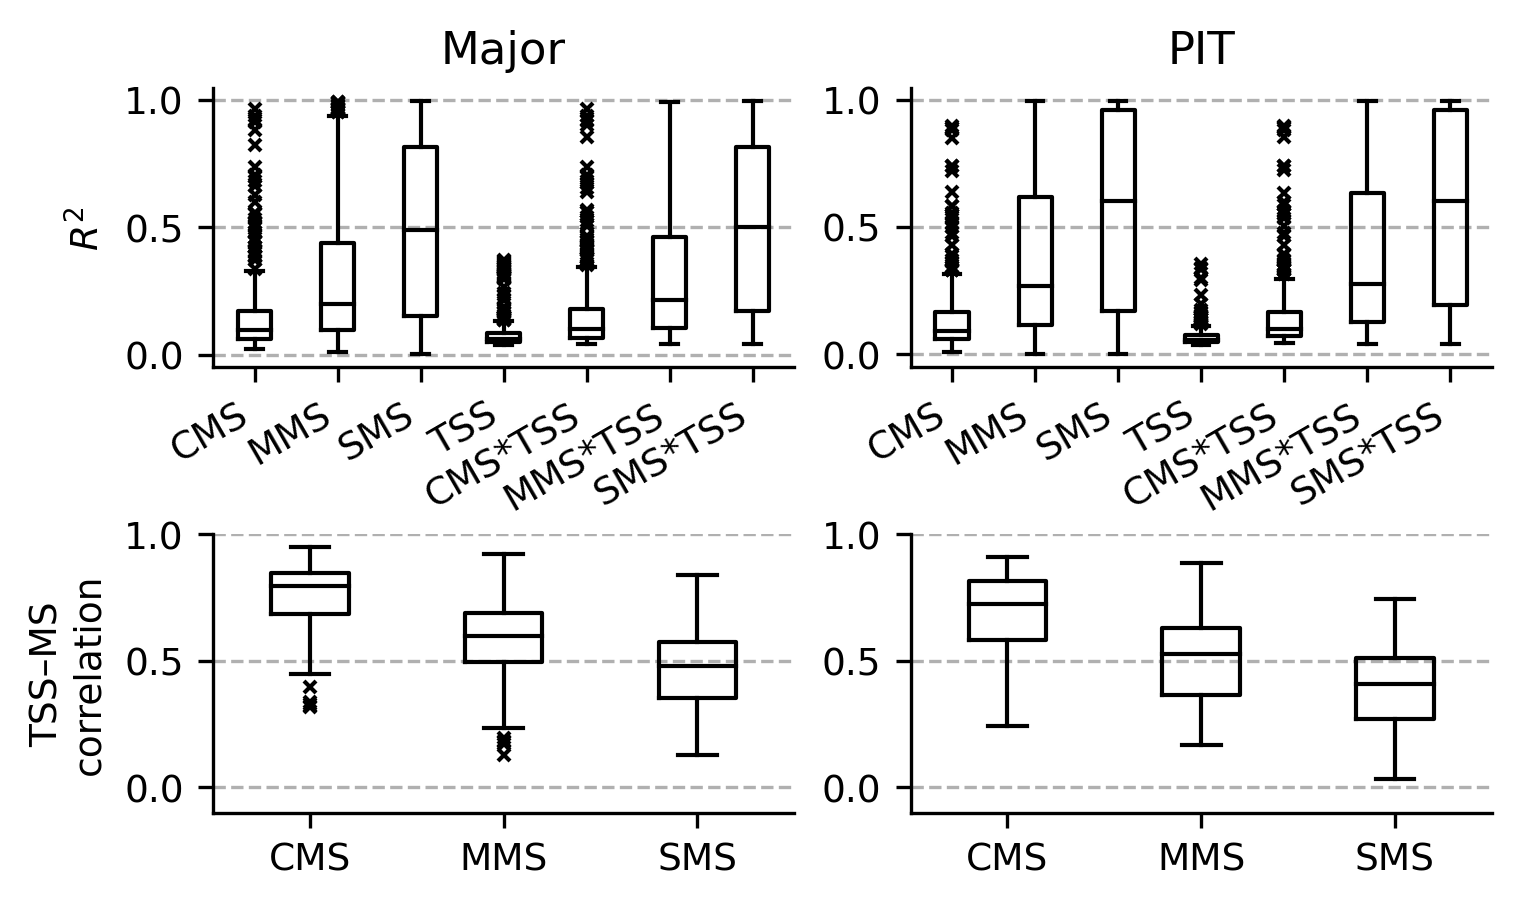

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 9}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(2, 2, figsize=(5.5, 3.2,), dpi=300)
fig.subplots_adjust(hspace=0.6)

columns = ["CMS", "MMS", "SMS", "TSS", "CMS*TSS", "MMS*TSS", "SMS*TSS"]
titles = ["Major", "PIT"]
for idx, obj in enumerate([(major, major_cor,), (pit, pit_cor,)]):
    obj, cor = obj
    df = pd.DataFrame(obj)
    df.columns = columns
    ax = df.boxplot(showfliers=True, ax = axs[0, idx], medianprops=util.medianprops, widths=0.4, color=util.colorprops, boxprops=util.boxprops, flierprops=util.flierprops)
    ax.set_title(titles[idx])
    ax.set_yticks([0, 0.5, 1])
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha="right")
    if idx == 0:
        ax.set_ylabel("$R^2$")
#         ax.set_xticks([]) 
#     ax.set_title(titles[idx])
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().grid(False)
    ax.get_yaxis().grid(True, linestyle='--')

    cor.columns = ["CMS", "MMS", "SMS"]
    ax = cor.boxplot(ax=axs[1, idx], showfliers=True, medianprops=util.medianprops, widths=0.4, color=util.colorprops, boxprops=util.boxprops, flierprops=util.flierprops)
    ax.set_yticks([0, 0.5, 1])
    if idx == 0:
        ax.set_ylabel("TSS–MS\ncorrelation")
#         ax.set_xticks([])

    ax.set_ylim(-0.1, 1)
    ax.get_xaxis().grid(False)
    ax.get_yaxis().grid(True, linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
# plt.show()


# fig.add_subplot(111, frame_on=False)
# plt.tick_params(labelcolor="none", bottom=False, left=False)
# plt.ylabel("$R^2$")
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
# fig.tight_layout()
# fig.savefig('../seke/fig3.png', format='png', dpi=300,bbox_inches='tight')
# print(stats.wilcoxon(df["CMS"], df["MMS"]))
# print(stats.wilcoxon(df["CMS"], df["SMS"]))

# major_axs, pit_axs = axs
# major_cor.boxplot(ax=major_axs, showfliers=True, medianprops=util.medianprops, widths=0.4, color=util.colorprops, boxprops=util.boxprops, flierprops=util.flierprops)
# major_axs.set_title("Major")
# pit_axs.set_title("PIT")
# major_axs.set_ylabel("Correlation")

# for axis in axs:
    

plt.savefig('../seke/fig4.png', format='png', dpi=300, bbox_inches='tight')
# plt.show()